In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, chi2
from category_encoders.target_encoder import TargetEncoder, OrdinalEncoder
from sklearn import tree
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, precision_recall_fscore_support
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

from sklearn.utils import class_weight

import shap
shap.initjs()

In [147]:
X = pd.read_csv('Training Dataset/Training_Dataset.csv')
repackaged_benign_test_X =  pd.read_csv('Test Dataset/Repackaged_Benign_Testset.csv')
covid_test_X = pd.read_csv('Test Dataset/COVID_Testset.csv')

In [148]:
y = pd.read_csv('Training Dataset/Labels.csv')
repackaged_benign_test_y = pd.read_csv('Test Dataset/Labels_Repackaged_Benign_Test.csv')
COVID_test_y = pd.read_csv('Test Dataset/Labels_COVID_Test.csv')

In [149]:
# Delete useless features told by Shirish
X.drop(['Package_Name', 'SHA256', 'ThumbPrint', 'Application_Category', 
        'Family_Name', 'Malware_Category', 'Malware/Benign'], axis = 1, inplace = True)

repackaged_benign_test_X.drop(['Package_Name', 'SHA256', 'ThumbPrint', 'Application_Category', 
                               'Family_Name', 'Malware_Category', 'Malware/Benign'], axis = 1, inplace = True)

covid_test_X.drop(['Package_Name', 'SHA256', 'ThumbPrint', 'Application_Category', 
                 'Family_Name', 'Malware_Category', 'Malware/Benign'], axis = 1, inplace = True)

## Feature Exploration

#### Find the one-hot features having missing values

In [150]:
X.describe().loc['count'][X.describe().loc['count'] < 10951]

sdkVersion          0.0
targetSdkVersion    0.0
Name: count, dtype: float64

In [151]:
# Delete these useless features (100% missing values)
X = X.drop(['sdkVersion', 'targetSdkVersion'], axis = 1)
repackaged_benign_test_X = repackaged_benign_test_X.drop(['sdkVersion', 'targetSdkVersion'], axis = 1)
covid_test_X = covid_test_X.drop(['sdkVersion', 'targetSdkVersion'], axis = 1)

In [152]:
# Check if there's no onehot feature has missing values
X.describe().loc['count'][X.describe().loc['count'] < 11146]

Series([], Name: count, dtype: float64)

**There's no one-hot features having missing values**

#### Remove features with 0 variance

In [153]:
X.max()[X.max() == 0].index.to_list()

['Permission: REQUEST_DELETE_PACKAGES',
 'Permission: BIND_MIDI_DEVICE_SERVICE',
 'Permission: BIND_TV_INPUT',
 'Permission: com.android.voicemail.permission.ADD_VOICEMAIL',
 'Permission: com.android.launcher.permission.UNINSTALL_SHORTCUT',
 'Permission: READ_PHONE_NUMBERS',
 'Permission: GET_ACCOUNTS_PRIVILEGED',
 'Permission: REQUEST_COMPANION_RUN_IN_BACKGROUND',
 'Permission: ANSWER_PHONE_CALLS',
 'Permission: BIND_CARRIER_SERVICES',
 'Permission: REQUEST_IGNORE_BATTERY_OPTIMIZATIONS',
 'Permission: ACCESS_NOTIFICATION_POLICY',
 'Permission: com.android.voicemail.permission.READ_VOICEMAIL',
 'Permission: BODY_SENSORS',
 'Permission: BIND_SCREENING_SERVICE',
 'Permission: REQUEST_COMPANION_USE_DATA_IN_BACKGROUND',
 'Permission: BIND_TELECOM_CONNECTION_SERVICE',
 'Permission: BIND_VOICE_INTERACTION',
 'Permission: BIND_CHOOSER_TARGET_SERVICE',
 'Permission: com.android.launcher.permission.INSTALL_SHORTCUT',
 'Permission: BIND_AUTOFILL_SERVICE',
 'Permission: USE_FINGERPRINT',
 'Permis

In [154]:
drop_features = X.max()[X.max() == 0].index.to_list()
X.drop(drop_features, axis = 1, inplace = True)
repackaged_benign_test_X.drop(drop_features, axis = 1, inplace = True)
covid_test_X.drop(drop_features, axis = 1, inplace = True)

## Feature Summary:


### Original Dataset:

#### (1) Missing Values:
   + Features with 100% missing values: 'sdkVersion', 'targetSdkVersion' (deleted)


#### (2) Features with 0 Variance:
  + Number of Features with 0 Variance: 511 (deleted)


### Preprocessed Dataset:

#### (1) Categories of Features:
  + Number of one-hot features: 353
 
 
#### (2) Features Extracted by Us
  + Number of featuers extracted by us (sensors): 29

## Correlation Between Features and Target

In [155]:
chi_2, p = chi2(X, y)

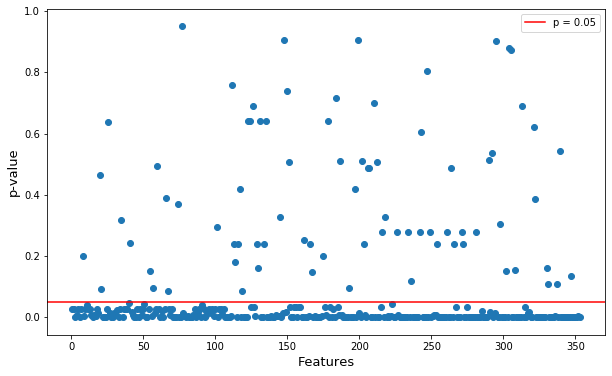

In [156]:
plt.figure(figsize = (10, 6))
plt.scatter(np.arange(1, 354), p)
plt.axhline(y=0.05, color='r', linestyle='-', label = 'p = 0.05')
plt.xlabel('Features', fontsize = 13)
plt.ylabel('p-value', fontsize = 13)
plt.legend()

In [157]:
print('The number of features that are correlated with the target (p-value < 0.05) is:', np.sum(p < 0.05))

The number of features that are correlated with the target (p-value < 0.05) is: 273


## Distribution of Target

Text(0.5, 1.0, 'Distribution of Target')

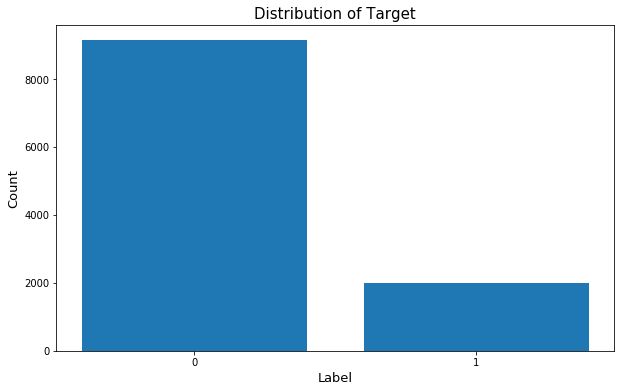

In [158]:
plt.figure(figsize = (10, 6))
plt.bar(['0', '1'], y['label'].value_counts().values)
plt.xlabel('Label', fontsize = 13)
plt.ylabel('Count', fontsize = 13)
plt.title('Distribution of Target', fontsize = 15)

  + **Need to deal with imbalanced dataset.**

In [159]:
# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y),
                                                  y['label'].values)
print("Class weights should be: %f for 0 and %f for 1" % (class_weights[0], class_weights[1]))

Class weights should be: 2.780938 for 0 and 0.609604 for 1


In [160]:
class_weights = {0: class_weights[0], 1: class_weights[1]}

## Splitting Training and Test set

In [161]:
# Create dataset without sensor features in order to see if there's some improvement by adding sensor features
X_wo_sensors = X.drop(X.iloc[:, -30:-1].columns, axis = 1)
repackaged_benign_test_X_wo_sensors = repackaged_benign_test_X.drop(X.iloc[:, -30:-1].columns, axis = 1)
covid_test_X_wo_sensors = covid_test_X.drop(X.iloc[:, -30:-1].columns, axis = 1)

In [162]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 123, 
                                                    stratify = y)

X_train_wo_sensor, X_test_wo_sensor, y_train_wo_sensor, y_test_wo_sensor = train_test_split(X_wo_sensors, y, 
                                                                                            test_size = 0.2, 
                                                                                            random_state = 123, 
                                                                                            stratify = y)

In [163]:
y_train['label'].value_counts()

1    7313
0    1603
Name: label, dtype: int64

## Building Pipelines and Training Logistic Regression Model

In [67]:
continuous = make_column_selector(dtype_exclude = 'object')

pipe = make_pipeline(SelectKBest(k = 273, score_func = chi2), 
                     LogisticRegression(class_weight = class_weights, max_iter = 1000))

In [68]:
avg_val_score = np.mean(cross_val_score(pipe, X_train, np.squeeze(y_train.to_numpy().reshape(1, -1)), cv = 5, scoring = 'balanced_accuracy'))
print('The mean test score of Logistic Regression model with sensor features is:', avg_val_score)

The mean test score of Logistic Regression model with sensor features is: 0.8319870099544484


In [70]:
avg_val_score = np.mean(cross_val_score(pipe, X_train_wo_sensor, np.squeeze(y_train_wo_sensor.to_numpy().reshape(1, -1)), cv = 5, scoring = 'balanced_accuracy'))
print('The mean test score of Logistic Regression model without sensor features is:', avg_val_score)

The mean test score of Logistic Regression model without sensor features is: 0.8218339758871199


## Tuning Hyperparameters

**1. Training on Dataset Including Sensor Features**

In [81]:
# Tune C of Logistic Regression
pipe_with_sensor = make_pipeline(SelectKBest(k = 200, score_func = chi2), 
                                 LogisticRegression(class_weight = class_weights, max_iter = 1000))

params = {'logisticregression__C': [0.6, 0.65, 0.7, 0.75, 0.8, 0.9]}

grid_with_sensor = GridSearchCV(pipe_with_sensor, param_grid = params, scoring = "balanced_accuracy")
grid_with_sensor.fit(X_train, y_train['label'].values)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('selectkbest',
                                        SelectKBest(k=200,
                                                    score_func=<function chi2 at 0x7f8f6f221440>)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight={0: 2.780938123752495,
                                                                         1: 0.6096040253773791},
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=1000,
    

In [82]:
grid_with_sensor.best_params_

{'logisticregression__C': 0.7}

In [83]:
result_with_sensor = pd.DataFrame(grid_with_sensor.cv_results_)

Text(0.5, 1.0, 'Mean Test Score of Logistic Regression with Different C (Including Sensor Features)')

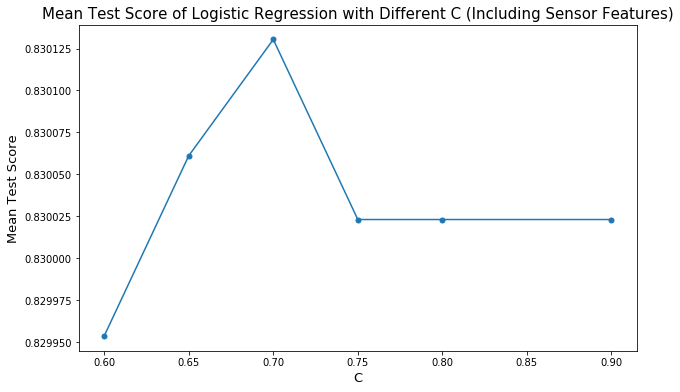

In [85]:
scores = result_with_sensor['mean_test_score']
scores_std = result_with_sensor['std_test_score']
std_error = scores_std / np.sqrt(5)
plt.figure(figsize = (10, 6))
plt.plot([0.6, 0.65, 0.7, 0.75, 0.8, 0.9], scores, marker = 'o', markersize = 5)
plt.xlabel('C', fontsize = 13)
plt.ylabel('Mean Test Score', fontsize = 13)
plt.title('Mean Test Score of Logistic Regression with Different C (Including Sensor Features)', fontsize = 15)

**2. Training on Dataset Not Including Sensor Features**

In [108]:
pipe_wo_sensor = make_pipeline(SelectKBest(k = 200, score_func = chi2), 
                               LogisticRegression(class_weight = class_weights, max_iter = 1000))

params = {'logisticregression__C': [3, 3.3, 3.4, 3.5, 3.7, 3.8, 4]}

grid_wo_sensor = GridSearchCV(pipe_wo_sensor, param_grid = params, scoring = 'balanced_accuracy')
grid_wo_sensor.fit(X_train_wo_sensor, y_train['label'].values)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('selectkbest',
                                        SelectKBest(k=200,
                                                    score_func=<function chi2 at 0x7f8f6f221440>)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight={0: 2.780938123752495,
                                                                         1: 0.6096040253773791},
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=1000,
    

In [109]:
result_wo_sensor = pd.DataFrame(grid_wo_sensor.cv_results_)

Text(0.5, 1.0, 'Mean Test Score of Logistic Regression with Different C (Not Including Sensor Features)')

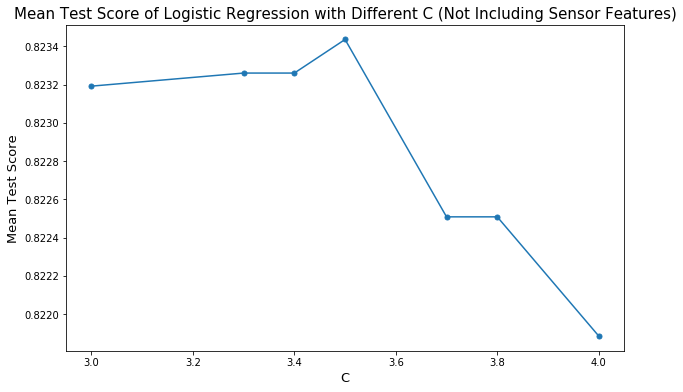

In [110]:
scores = result_wo_sensor['mean_test_score']
scores_std = result_wo_sensor['std_test_score']
std_error = scores_std / np.sqrt(5)
plt.figure(figsize = (10, 6))
plt.plot([3, 3.3, 3.4, 3.5, 3.7, 3.8, 4], scores, marker = 'o', markersize = 5)
plt.xlabel('C', fontsize = 13)
plt.ylabel('Mean Test Score', fontsize = 13)
plt.title('Mean Test Score of Logistic Regression with Different C (Not Including Sensor Features)', fontsize = 15)

## Testing

In [164]:
y_pred_with_sensor = grid_with_sensor.predict_proba(X_test)
y_pred_wo_sensor = grid_wo_sensor.predict_proba(X_test_wo_sensor)

In [166]:
np.save('y_pred_with_sensor_LR.npy', y_pred_with_sensor)
np.save('y_pred_wo_sensor_LR.npy', y_pred_wo_sensor)

AUC (including sensor features) 0.9078574749566759
AUC (not including sensor features) 0.9038509521712396


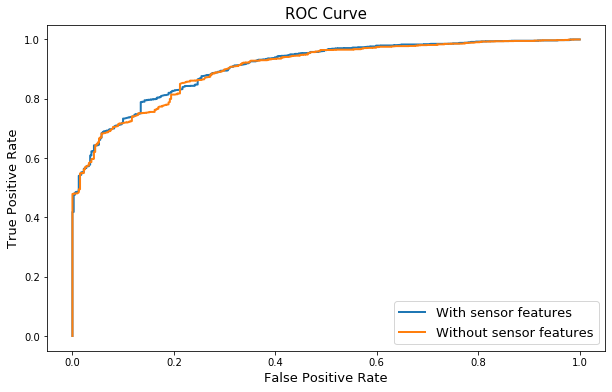

In [112]:
plt.figure(figsize = (10, 6))
fpr, tpr, _ = roc_curve(y_test['label'].values, y_pred_with_sensor[:, 1])
fpr2, tpr2, _2 = roc_curve(y_test['label'].values, y_pred_wo_sensor[:, 1])
plt.plot(fpr, tpr, lw=2, label='With sensor features')
plt.plot(fpr2, tpr2, lw=2, label='Without sensor features')
print('AUC (including sensor features)', roc_auc_score(y_test, y_pred_with_sensor[:, 1]))
print('AUC (not including sensor features)', roc_auc_score(y_test, y_pred_wo_sensor[:, 1]))

plt.xlabel('False Positive Rate', fontsize = 13)
plt.ylabel('True Positive Rate', fontsize = 13)
plt.title('ROC Curve', fontsize = 15)
plt.legend(fontsize = 13)

In [135]:
y_pred_with_sensor = grid_with_sensor.predict(X_test)
y_pred_wo_sensor = grid_wo_sensor.predict(X_test_wo_sensor)

In [136]:
precision_recall_fscore_support(y_test['label'].values, y_pred_with_sensor)

(array([0.49542683, 0.95171537]),
 array([0.81047382, 0.81902679]),
 array([0.61494797, 0.88039965]),
 array([ 401, 1829]))

In [137]:
precision_recall_fscore_support(y_test['label'].values, y_pred_wo_sensor)

(array([0.45582048, 0.94990112]),
 array([0.81047382, 0.78786222]),
 array([0.58348294, 0.86132696]),
 array([ 401, 1829]))

**Adding sensor features slightly improves the Logistic Regression model's performance.**

## Other Metrics

In [117]:
print('Balanced Average Accuracy (including sensor features):', balanced_accuracy_score(y_test['label'].values, y_pred_with_sensor))
print('Balanced Average Accuracy (not including sensor features):', balanced_accuracy_score(y_test_wo_sensor['label'].values, y_pred_wo_sensor))

Balanced Average Accuracy (including sensor features): 0.8147503030286504
Balanced Average Accuracy (not including sensor features): 0.7991680176267915


## Testing on Repackaged Benign Apps Dataset

In [118]:
# X.drop(['Package_Name', 'SHA256', 'ThumbPrint', 'Application_Category', 
#         'Family_Name', 'Malware_Category', 'Malware/Benign', 'sdkVersion', 
#         'targetSdkVersion'], axis = 1, inplace = True)
# X.drop(drop_features, axis = 1, inplace = True)

In [120]:
accuracy = grid_with_sensor.score(repackaged_benign_test_X, repackaged_benign_test_y['label'].values)

y_pred contains classes not in y_true


In [121]:
print('Accuracy (including sensor features):', accuracy)

Accuracy (including sensor features): 0.8037088873337999


+ **Logistic Regression can classify 80.4% repackaged benign apps correctly, but still misclassify 19.6% cases.**

In [123]:
accuracy = grid_wo_sensor.score(repackaged_benign_test_X_wo_sensors, repackaged_benign_test_y['label'].values)

y_pred contains classes not in y_true


In [124]:
print('Accuracy (including sensor features):', accuracy)

Accuracy (including sensor features): 0.7984604618614416


## Paired or Non-paired

In [138]:
pairs = pd.read_csv('repackaging_pairs.txt')

In [139]:
X = pd.read_csv('Training Dataset/Training_Dataset.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 123, 
                                                    stratify = y)

In [140]:
paired_w_sensor_accuracy = []
non_paired_w_sensor_accuracy = []
paired_wo_sensor_accuracy = []
non_paired_wo_sensor_accuracy = []

visited = []
for i in range(X_test.shape[0]):
    acc1 = y_pred_with_sensor[i] == y_test.iloc[i]['label']
    acc2 = y_pred_wo_sensor[i] == y_test.iloc[i]['label']
    
    sha = X_test.iloc[i]['SHA256']
    
    for idx in pairs.index:
        if sha == pairs.loc[idx, 'SHA256_ORIGINAL']:
            if pairs.loc[idx, 'SHA256_REPACKAGE'] in X_test['SHA256'].values:
                paired_w_sensor_accuracy.append(acc1)
                paired_wo_sensor_accuracy.append(acc2)
            else:
                non_paired_w_sensor_accuracy.append(acc1)
                non_paired_wo_sensor_accuracy.append(acc2)
            break
        elif sha == pairs.loc[idx, 'SHA256_REPACKAGE']:
            if pairs.loc[idx, 'SHA256_ORIGINAL'] in X_test['SHA256'].values:
                paired_w_sensor_accuracy.append(acc1)
                paired_wo_sensor_accuracy.append(acc2)
            else:
                non_paired_w_sensor_accuracy.append(acc1)  
                non_paired_wo_sensor_accuracy.append(acc2)  
            break

In [141]:
acc_1 = []
acc_2 = []
for i in range(X_test.shape[0]):
    acc1 = y_pred_with_sensor[i] == y_test.iloc[i]['label']
    acc2 = y_pred_wo_sensor[i] == y_test.iloc[i]['label']
    
    acc_1.append(acc1)
    acc_2.append(acc2)

In [142]:
np.sum(acc_1)

1823

In [143]:
len(paired_w_sensor_accuracy)

227

In [144]:
len(non_paired_w_sensor_accuracy)

2003

In [145]:
print("Accuracy for paired apps (including sensor features):", np.sum(paired_w_sensor_accuracy)/len(paired_w_sensor_accuracy))
print("Accuracy for non-paired apps (including sensor features):", np.sum(non_paired_w_sensor_accuracy)/len(non_paired_w_sensor_accuracy))

print("Accuracy for paired apps (not including sensor features):", np.sum(paired_wo_sensor_accuracy)/len(paired_wo_sensor_accuracy))
print("Accuracy for non-paired apps (not including sensor features):", np.sum(non_paired_wo_sensor_accuracy)/len(non_paired_wo_sensor_accuracy))

Accuracy for paired apps (including sensor features): 0.7092511013215859
Accuracy for non-paired apps (including sensor features): 0.8297553669495756
Accuracy for paired apps (not including sensor features): 0.6916299559471366
Accuracy for non-paired apps (not including sensor features): 0.8032950574138792


## Testing on COVID Dataset

In [125]:
covid_test_X.fillna(0, inplace = True)

In [126]:
covid_y_pred_w_sensor = grid_with_sensor.predict(covid_test_X)
covid_y_pred_wo_sensor = grid_wo_sensor.predict(covid_test_X_wo_sensors)

In [134]:
print('Number of malware detected:', np.sum(covid_y_pred_w_sensor * COVID_test_y['label'].values))

Number of malware detected: 3


In [127]:
print('Balanced Average Accuracy (including sensor features):', balanced_accuracy_score(COVID_test_y['label'].values, covid_y_pred_w_sensor))
print('Balanced Average Accuracy (not including sensor features):', balanced_accuracy_score(COVID_test_y['label'].values, covid_y_pred_wo_sensor))


Balanced Average Accuracy (including sensor features): 0.5148875757808303
Balanced Average Accuracy (not including sensor features): 0.508518149029238


## Thumbprint Score

In [87]:
X_test['y_pred_with_sensor'] = y_pred_with_sensor
X_test['y_pred_wo_sensor'] = y_pred_wo_sensor
X_test['label'] = y_test['label'].values


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [88]:
# scores of top 10 authors
X_test['correct'] = X_test['label'] == X_test['y_pred_with_sensor']
summ = X_test[X_test['label']==1].groupby('ThumbPrint').agg(N=('SHA256','count'),
                                                      correct=('correct','sum'))\
.sort_values(['N','correct'], ascending=False).iloc[:10,:]
summ['score'] = summ['correct']/summ['N']
summ


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,N,correct,score
ThumbPrint,,,
61ED377E85D386A8DFEE6B864BD85B0BFAA5AF81,162,96.0,0.592593
28EAC321D548B4247D9C84810C0656EC9426716B,97,66.0,0.680412
F3FA0BE3FEB31AC2920E399AF0F0CFB37D729284,71,71.0,1.000000
95653B2BD67722B6EF4021CB812FF2B4DC5DCF03,67,67.0,1.000000
00F7DCC41988D8642C51D4F8BA5A42C413275885,58,58.0,1.000000
F243B92AD5EABA98BD43084864C4D5483F191CD9,52,40.0,0.769231
45A195BE1E17B3AFA086623DCC4661DEE2043B70,45,45.0,1.000000
6C699C8D1F7157366994ACDA5495051F2C58D7AB,44,44.0,1.000000
699512C8B49E7A01A622BD250544E09A80A42D55,39,33.0,0.846154


In [68]:
pipe_with_sensor = LogisticRegression(C = grid_with_sensor.best_params_['logisticregression__C'], 
                                      class_weight = class_weights, max_iter = 1000)
pipe_with_sensor.fit(X, y['label'].values)

pipe_wo_sensor = LogisticRegression(C = grid_wo_sensor.best_params_['logisticregression__C'],
                                    class_weight = class_weights, max_iter = 1000)
pipe_wo_sensor.fit(X_wo_sensors, y['label'].values)

LogisticRegression(C=0.5,
                   class_weight={0: 2.780938123752495, 1: 0.6096040253773791},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=1000, multi_class='auto',
                   n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)

61ED377E85D386A8DFEE6B864BD85B0BFAA5AF81


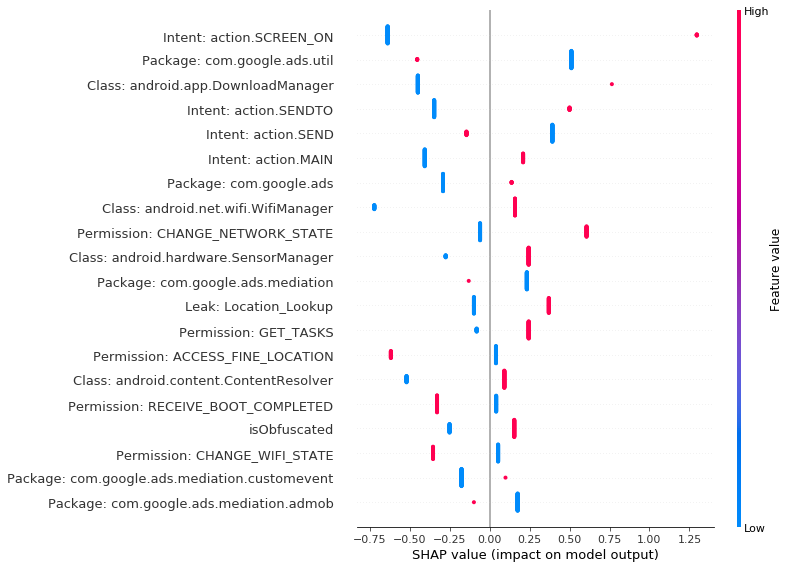

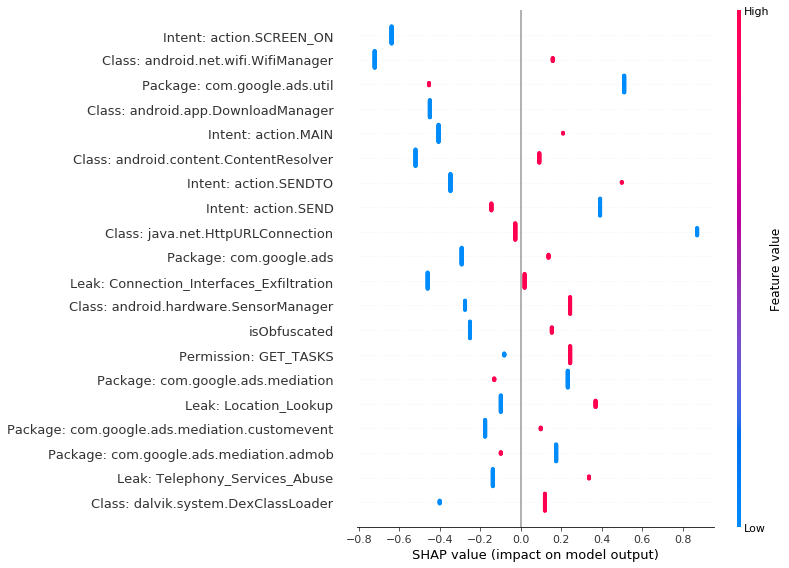

28EAC321D548B4247D9C84810C0656EC9426716B


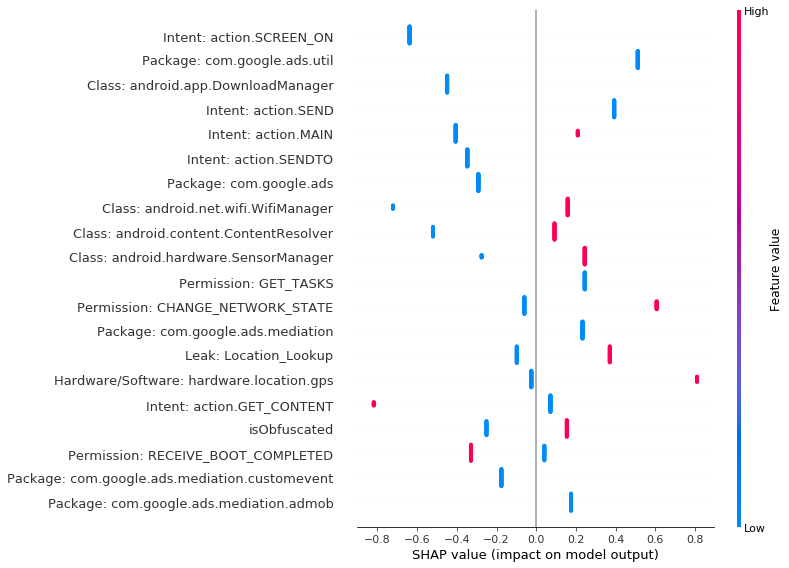

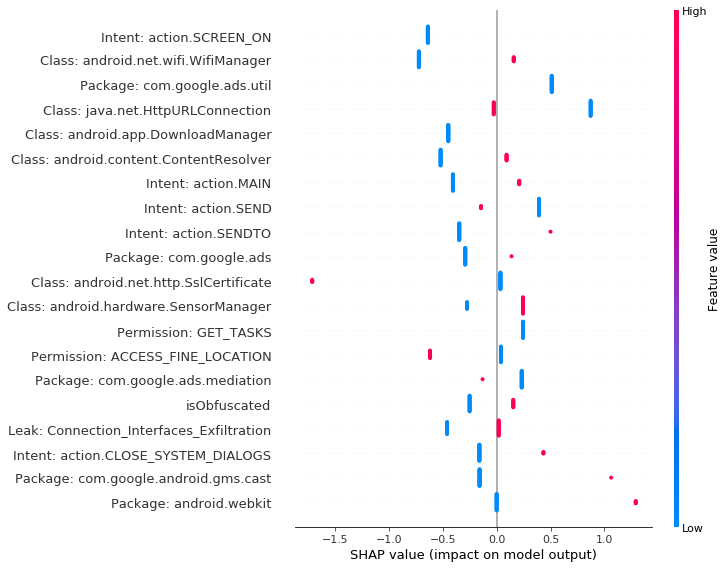

F243B92AD5EABA98BD43084864C4D5483F191CD9


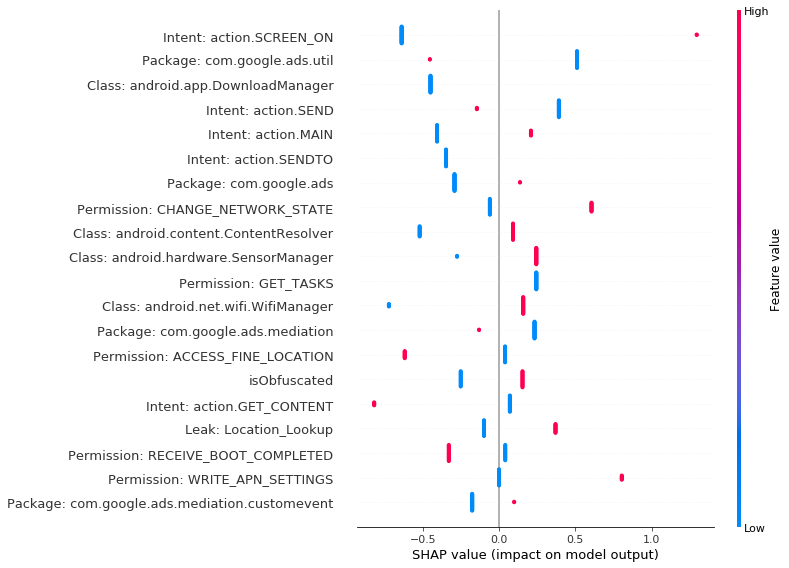

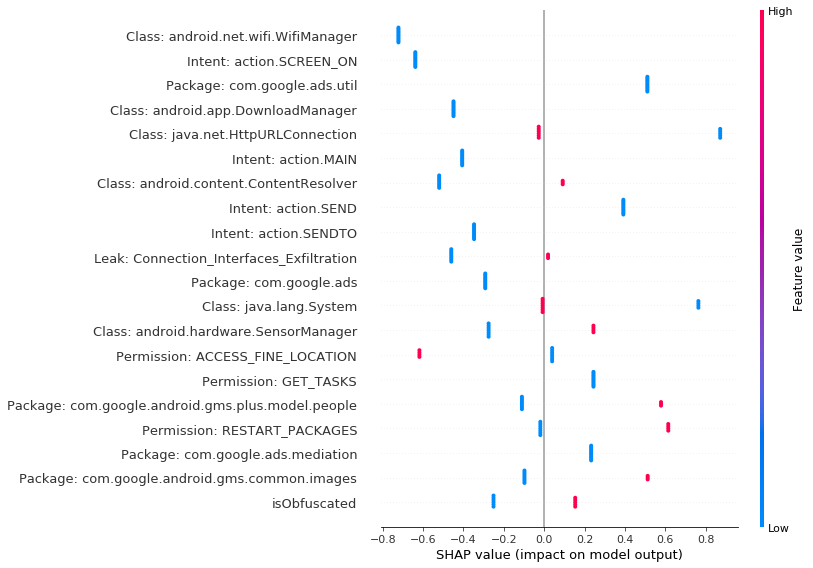

699512C8B49E7A01A622BD250544E09A80A42D55


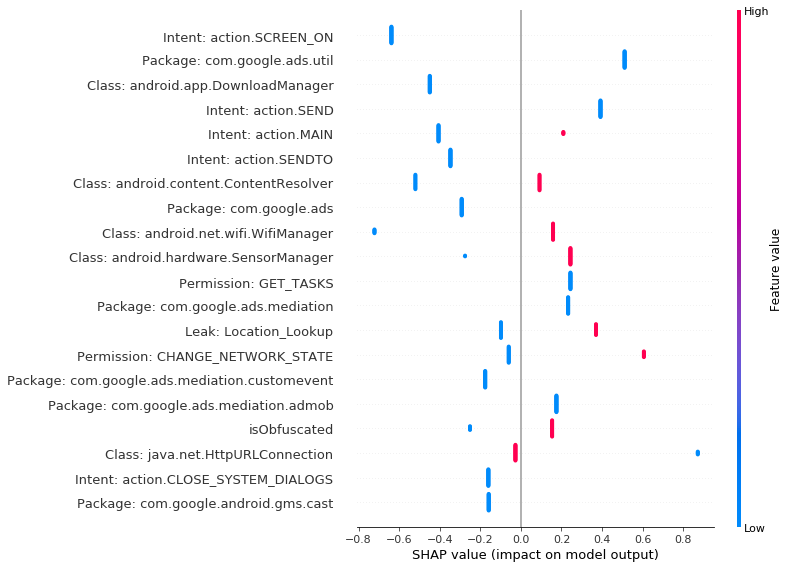

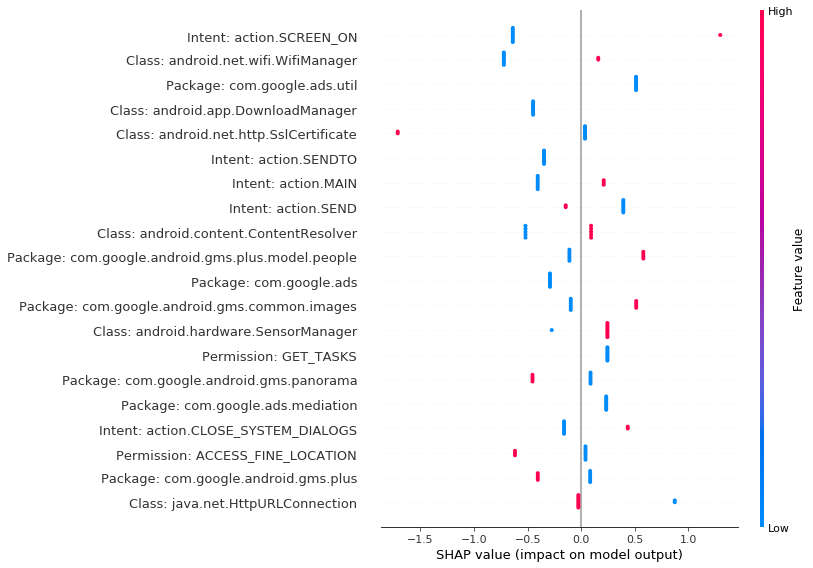

5BFC55F389F4B5427341E4320A501711140AE444


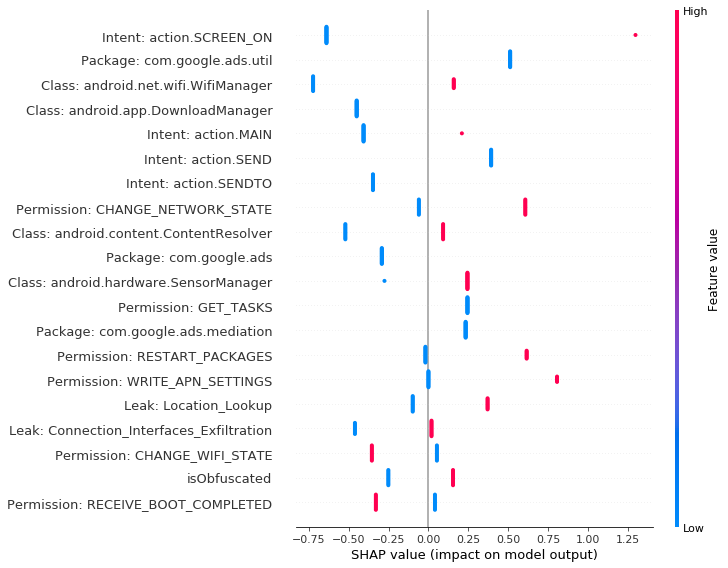

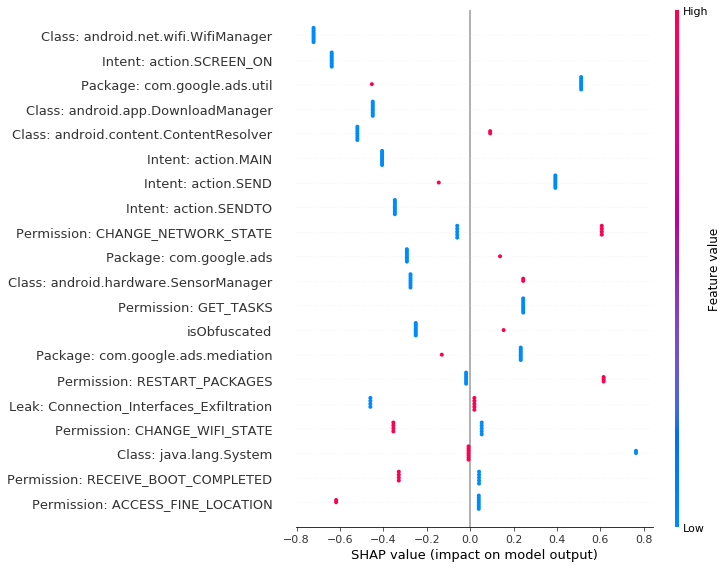

In [72]:
for tp in summ.index:
    
    record = X_test[(X_test['ThumbPrint'] == tp) & (X_test['label'] == 1)]
    correct = record[record['correct'] == True]
    incorrect = record[record['correct'] == False]
    
    if incorrect.shape[0] > 0:
        print(tp)
        correct.drop(['Package_Name', 'SHA256', 'ThumbPrint', 'Application_Category', 
                      'Family_Name', 'Malware_Category', 'Malware/Benign', 'sdkVersion', 
                      'targetSdkVersion'], axis = 1, inplace = True)
        correct.drop(drop_features, axis = 1, inplace = True)
        correct.drop(['y_pred_with_sensor', 'y_pred_wo_sensor', 'label', 'correct'], axis = 1, inplace = True)
    
        incorrect.drop(['Package_Name', 'SHA256', 'ThumbPrint', 'Application_Category', 
                        'Family_Name', 'Malware_Category', 'Malware/Benign', 'sdkVersion', 
                        'targetSdkVersion'], axis = 1, inplace = True)
        incorrect.drop(drop_features, axis = 1, inplace = True)
        incorrect.drop(['y_pred_with_sensor', 'y_pred_wo_sensor', 'label', 'correct'], axis = 1, inplace = True)
    
        explainer1 = shap.LinearExplainer(pipe_with_sensor, X)
        shap_values1 = explainer1.shap_values(correct)
        shap.summary_plot(shap_values1, correct, feature_names = correct.columns)
    
        explainer2 = shap.LinearExplainer(pipe_with_sensor, X)
        shap_values2 = explainer2.shap_values(incorrect)
        shap.summary_plot(shap_values2, incorrect, feature_names = correct.columns)

In [89]:
# scores of top 10 authors
X_test['correct'] = X_test['label'] == X_test['y_pred_wo_sensor']
summ = X_test[X_test['label']==1].groupby('ThumbPrint').agg(N=('SHA256','count'),
                                                      correct=('correct','sum'))\
.sort_values(['N','correct'], ascending=False).iloc[:10,:]
summ['score'] = summ['correct']/summ['N']
summ


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,N,correct,score
ThumbPrint,,,
61ED377E85D386A8DFEE6B864BD85B0BFAA5AF81,162,92.0,0.567901
28EAC321D548B4247D9C84810C0656EC9426716B,97,62.0,0.639175
F3FA0BE3FEB31AC2920E399AF0F0CFB37D729284,71,71.0,1.000000
95653B2BD67722B6EF4021CB812FF2B4DC5DCF03,67,67.0,1.000000
00F7DCC41988D8642C51D4F8BA5A42C413275885,58,0.0,0.000000
F243B92AD5EABA98BD43084864C4D5483F191CD9,52,41.0,0.788462
45A195BE1E17B3AFA086623DCC4661DEE2043B70,45,45.0,1.000000
6C699C8D1F7157366994ACDA5495051F2C58D7AB,44,44.0,1.000000
699512C8B49E7A01A622BD250544E09A80A42D55,39,33.0,0.846154


## Diving Into ThumpPrint Score

In [113]:
pairs = pd.read_csv('repackaging_pairs.txt')

In [191]:
dataset = pd.read_csv('Training Dataset/Training_Dataset.csv')
X_train, X_test, y_train, y_test = train_test_split(dataset, y, 
                                                    test_size = 0.2, 
                                                    random_state = 123, 
                                                    stratify = y)

In [192]:
X = dataset.drop(['Package_Name', 'ThumbPrint', 'Application_Category', 
                  'Family_Name', 'Malware_Category', 'Malware/Benign', 'sdkVersion', 
                  'targetSdkVersion'], axis = 1)
X.drop(drop_features, axis = 1, inplace = True)

In [193]:
X_test['y_pred_with_sensor'] = list(y_pred_with_sensor)
X_test['label'] = y_test['label'].values


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [194]:
# scores of top 10 authors
X_test['correct'] = X_test['label'] == X_test['y_pred_with_sensor']
summ = X_test[X_test['label']==1].groupby('ThumbPrint').agg(N=('SHA256','count'),
                                                      correct=('correct','sum'))\
.sort_values(['N','correct'], ascending=False).iloc[:10,:]
summ['score'] = summ['correct']/summ['N']
summ


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,N,correct,score
ThumbPrint,,,
61ED377E85D386A8DFEE6B864BD85B0BFAA5AF81,162,95.0,0.586420
28EAC321D548B4247D9C84810C0656EC9426716B,97,61.0,0.628866
F3FA0BE3FEB31AC2920E399AF0F0CFB37D729284,71,71.0,1.000000
95653B2BD67722B6EF4021CB812FF2B4DC5DCF03,67,67.0,1.000000
00F7DCC41988D8642C51D4F8BA5A42C413275885,58,58.0,1.000000
F243B92AD5EABA98BD43084864C4D5483F191CD9,52,41.0,0.788462
45A195BE1E17B3AFA086623DCC4661DEE2043B70,45,45.0,1.000000
6C699C8D1F7157366994ACDA5495051F2C58D7AB,44,44.0,1.000000
699512C8B49E7A01A622BD250544E09A80A42D55,39,29.0,0.743590


### Take 61ED377E85D386A8DFEE6B864BD85B0BFAA5AF81 as an example.

In [143]:
example_malware = X_test[(X_test['ThumbPrint'] == '61ED377E85D386A8DFEE6B864BD85B0BFAA5AF81') & (X_test['label'] == 1)][['SHA256', 'label', 'correct']]
original_apps = []
for i in range(example_malware.shape[0]):
    original_app = pairs[pairs['SHA256_REPACKAGE'] == example_malware.iloc[i]['SHA256']]['SHA256_ORIGINAL'].values
    original_apps.append(original_app[0])

example_malware['original_app'] = original_apps

In [156]:
unique_original_apps = example_malware['original_app'].unique()
original_app = []
total_number_malware = []
correctly_classified_malware = []
misclassified_malware = []
for app in unique_original_apps:
    original_app.append(app)
    total_number_malware.append(example_malware[example_malware['original_app'] == app].shape[0])
    correctly_classified_malware.append(example_malware[example_malware['original_app'] == app]['correct'].sum())
    misclassified_malware.append(example_malware[example_malware['original_app'] == app].shape[0]-example_malware[example_malware['original_app'] == app]['correct'].sum())
    
summization = pd.DataFrame({'Original App': original_app, 'Total Number of Malware': total_number_malware, 
                            'Correctly Classified Malware': correctly_classified_malware, 
                            'Misclassified Malware': misclassified_malware})
    

In [158]:
summization['Times'] = summization['Correctly Classified Malware'] * summization['Misclassified Malware']

In [168]:
summization

,Original App,Total Number of Malware,Correctly Classified Malware,Misclassified Malware,Times
0,DC2839B99397C572CFA680B5E9BDA56E2511A9FD1892D0...,3,3,0,0
1,B89A19FD64AA4E20C0C4F69D420B6A634D2577C2EF8C75...,4,0,4,0
2,504577D68F6B561B34DB95EC8A9B00ABAC28075DD2143A...,5,0,5,0
3,CB29ECB8FD2BC59F953E6E67D0329B2A4EFB70E03FAFCA...,14,14,0,0
4,C5616B147FC273EAF29B407704C5D9475CB507015B06FD...,2,2,0,0
...,...,...,...,...,...
95,4A2760C81B31538F5E19501EA663B3F1A8970134C537E7...,2,0,2,0
96,967C5C42D5476BEE83291E36FBD6AF54ED2AE1BB6C7B6B...,1,1,0,0
97,98FED14EDD184A1B43FA253E91651D6D1B20C02CBF7D43...,1,0,1,0
98,D096AD8C6D7D1CF06D4217E315598108F7A52BED302C1B...,1,1,0,0


In [170]:
summization[summization['Misclassified Malware'] != 0]

,Original App,Total Number of Malware,Correctly Classified Malware,Misclassified Malware,Times
1,B89A19FD64AA4E20C0C4F69D420B6A634D2577C2EF8C75...,4,0,4,0
2,504577D68F6B561B34DB95EC8A9B00ABAC28075DD2143A...,5,0,5,0
5,9CE26B56019BA91881F3810064908D25D62A964B13DFEF...,1,0,1,0
10,1D747AB698BF7A44F749133AD5CAAC707CB51F0EFB6CC0...,1,0,1,0
11,388E528D74ADF5CF7F455A273B52F7318D096987D69332...,1,0,1,0
12,FC8CE9783A984D6820015D3CE4411516F5FA14CEB23CC4...,1,0,1,0
16,3B895DD81D03F86AB97012589EA280F4ACBF3F8E0F90CE...,5,0,5,0
17,F53AF808D9A66F838567D3574372BC09F97AB9A854292F...,1,0,1,0
20,A48298AB475AF55BC4AB08E27AB8EE7FE1C7A636CD39EF...,1,0,1,0
24,ACA883D62B50E698D4C3446919FB2D89CA8C5A640924D8...,1,0,1,0


+ **Case 1**

In [178]:
original_apps = summization[(summization['Times'] == 0) & (summization['Misclassified Malware'] != 0)]\
                           ['Original App'].to_list()

In [215]:
df = pd.DataFrame(columns = ['Original App', 'Misclassified Malware', 'Jaccard Similarity', 'Malware Have More Features'])

for app in original_apps:
    original_app_features = X[X['SHA256'] == app].drop(['SHA256'], axis = 1).to_numpy()
    malware = example_malware[example_malware['original_app'] == app]['SHA256'].to_list()

    for mal in malware:
        malware_features = X[X['SHA256'] == mal].drop(['SHA256'], axis = 1).to_numpy()
        
        # Calculate Jaccard Similarity
        original_cnt = np.sum(original_app_features)
        repackaged_cnt = np.sum(malware_features)
        # Calculate how many same features that both of the original and repackaged apps use.
        features_both_have = np.sum(original_app_features * malware_features)
    
        # Calculate the total number of sensors the original and repackaged apps use.
        total_features_used = original_cnt + repackaged_cnt - features_both_have
        
        
        if total_features_used > 0:
            jaccard_similarity = features_both_have / total_features_used
            df = df.append({'Original App': app, 'Misclassified Malware': mal, 
                            'Jaccard Similarity': jaccard_similarity, 'Malware Have More Features': 1 if repackaged_cnt > original_cnt else 0},  
                      ignore_index = True) 
        else:
            df = df.append({'Original App': app, 'Misclassified Malware': mal, 
                            'Jaccard Similarity': None, 'Malware Have More Features': None},  
                      ignore_index = True) 


In [230]:
pd.set_option('display.max_rows', None)
df

,Original App,Misclassified Malware,Jaccard Similarity,Malware Have More Features
0,B89A19FD64AA4E20C0C4F69D420B6A634D2577C2EF8C75...,D3B6E792CD448B69DA2BB9B15A4D7DAD9897BC50BB5872...,1.000000,0
1,B89A19FD64AA4E20C0C4F69D420B6A634D2577C2EF8C75...,D2DFB829708638C1D723DA1CB20E7071C9D37892296660...,1.000000,0
2,B89A19FD64AA4E20C0C4F69D420B6A634D2577C2EF8C75...,6FF792D7D5D38E9DFFAA8EC97CFC8E29DF7E0A0D6DEA94...,1.000000,0
3,B89A19FD64AA4E20C0C4F69D420B6A634D2577C2EF8C75...,0F0DBC2FF4B792E0987488D927EC295745EB2DE3BEF140...,1.000000,0
4,504577D68F6B561B34DB95EC8A9B00ABAC28075DD2143A...,391160A4126B0A9DAE5BD11D4D4FD9CA82FD38CF9E2ECA...,1.000000,0
5,504577D68F6B561B34DB95EC8A9B00ABAC28075DD2143A...,7CA2F35C93BCE098D576FAF9CB486966650314646720E0...,1.000000,0
6,504577D68F6B561B34DB95EC8A9B00ABAC28075DD2143A...,09F0D70B91F1D0721F2C5BC04AB479246313CC9C042A34...,1.000000,0
7,504577D68F6B561B34DB95EC8A9B00ABAC28075DD2143A...,BDD5107F91C06FFF8F96D41D2B2905520B22987A5F006B...,1.000000,0
8,504577D68F6B561B34DB95EC8A9B00ABAC28075DD2143A...,F335C8B32EE3BD441FEC48D537816D8EB1FEF7782C49E3...,1.000000,0
9,9CE26B56019BA91881F3810064908D25D62A964B13DFEF...,57ABE57860B01ECB21E87D756B3F202DB4838EE24E44A7...,0.000000,1


In [264]:
df.iloc[1][1]

'D2DFB829708638C1D723DA1CB20E7071C9D37892296660D76C72687311ACC4FC'

In [259]:
df.to_csv('case1_Jaccard_Similarity.csv', index = False)

In [222]:
df['Jaccard Similarity'].value_counts()

1.000000    47
0.000000    11
0.694444     1
0.833333     1
0.894737     1
0.980769     1
0.958333     1
0.944444     1
0.925926     1
0.968750     1
Name: Jaccard Similarity, dtype: int64

In [224]:
df['Malware Have More Features'].value_counts()

0    52
1    14
Name: Malware Have More Features, dtype: int64

+ **Case 2**

In [231]:
original_apps = summization[(summization['Times'] != 0) & (summization['Misclassified Malware'] != 0)]\
                           ['Original App'].to_list()

In [256]:
df2 = pd.DataFrame(columns = ['Misclassified Malware', 'Correctly Classified Malware', 'Jaccard Similarity', 'Misclassified Malware Have More Features'])

for app in original_apps:
    malware = example_malware[example_malware['original_app'] == app]['SHA256'].to_list()
    correct = []
    incorrect = []
    for mal in malware:
        if X_test[X_test['SHA256'] == mal]['correct'].values[0]:
            correct.append(mal)
        else:
            incorrect.append(mal)
   
    for mal in incorrect:
        misclassified_malware_features = X[X['SHA256'] == mal].drop(['SHA256'], axis = 1).to_numpy()
        misclassified_malware_cnt = np.sum(misclassified_malware_features)
        for m in correct:
            classified_malware_features = X[X['SHA256'] == m].drop(['SHA256'], axis = 1).to_numpy()
            # Calculate Jaccard Similarity
            classified_malware_cnt = np.sum(classified_malware_features)
            # Calculate how many same features that both of the original and repackaged apps use.
            features_both_have = np.sum(misclassified_malware_features * classified_malware_features)
    
            # Calculate the total number of sensors the original and repackaged apps use.
            total_features_used = misclassified_malware_cnt + classified_malware_cnt - features_both_have
        
           
            if total_features_used > 0:
                jaccard_similarity = features_both_have / total_features_used
                df2 = df2.append({'Misclassified Malware': mal, 'Correctly Classified Malware': m, 
                                  'Jaccard Similarity': jaccard_similarity, 'Misclassified Malware Have More Features': 1 if misclassified_malware_cnt > classified_malware_cnt else 0},  
                                 ignore_index = True) 
            else:
                df2 = df2.append({'Misclassified Malware': mal, 'Correctly Classified Malware': m, 
                                  'Jaccard Similarity': None, 'Misclassified Malware Have More Features': None},  
                                 ignore_index = True) 

In [257]:
df2

,Misclassified Malware,Correctly Classified Malware,Jaccard Similarity,Misclassified Malware Have More Features
0,163BF040F106A00FECD137B8B5990DE61C42EC149F43AF...,E532932941210130143ABD36276F07538AE14375BB6E2D...,0.967742,0


In [260]:
df2.to_csv('case2_Jaccard_Similarity.csv', index = False)